In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import tectosaur.mesh.mesh_gen

from scipy.integrate import RK45
from scipy.optimize import fsolve
from qd_helpers import *

import os
os.environ['CUDA_DEVICE'] = str(7)

In [2]:
n_fault = 100
L = 8000
W = 8000
m = tectosaur.mesh.mesh_gen.make_rect(n_fault, n_fault, [
    [-L, 0, W], [-L, 0, -W],
    [L, 0, -W], [L, 0, W]
])
qdm = QDMeshData(m)

qd_cfg = dict(
    # Material properties
    sm = 2e10,          # Shear modulus (Pa)
    pr = 0.25,          # Poisson ratio 
    density = 2670,     # rock density (kg/m^3)

    # Frictional properties
    Dc = 0.012,         # state evolution length scale (m)
    f0 = 0.6,           # baseline coefficient of friction
    V0 = 1e-6,          # when V = V0, f = f0, V is (m/s)

    # Boundary conditions
    plate_rate = 1e-9,  # (m/s), equivalent to ~31.5 mm/yr
    
    # This is only necessary because this is a full space model and there's no concept of depth or gravity
    additional_normal_stress = 50e6, 
    
    # numerical preferences
    only_x = True, # slip/velocity/traction in the y,z directions are set = 0
    timestep_tol = 1e-3,
    
    tectosaur_cfg = dict(
        quad_mass_order = 4,       
        quad_vertadj_order = 8,
        quad_far_order = 3,
        quad_near_order = 5,
        quad_near_threshold = 2.5,
        float_type = np.float32,
        use_fmm = False,
        fmm_order = 150,
        fmm_mac = 3.0,
        pts_per_cell = 450,
        log_level = logging.INFO
    )
)
qd_cfg['cs'] = np.sqrt(qd_cfg['sm'] / qd_cfg['density'])# Shear wave speed (m/s)
qd_cfg['eta'] = qd_cfg['sm'] / (2 * qd_cfg['cs'])       # The radiation damping coefficient (kg / (m^2 * s))

In [3]:
dof_pts = m[0][m[1]].reshape((-1,3))

a = np.ones(dof_pts.shape[0]) * 0.010
b = np.ones_like(a) * 0.015
qd_cfg['a'] = a
qd_cfg['b'] = b
#plot_fields(qdm.m, np.vstack((qd_cfg['a'], qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'] < 0)).T)

In [4]:
mesh_L = np.max(np.sqrt(np.linalg.norm(qdm.unscaled_tri_normals, axis = 1)))
Lb = qd_cfg['sm'] * qd_cfg['Dc'] / (qd_cfg['additional_normal_stress'] * qd_cfg['b'])
hstar = (np.pi * qd_cfg['sm'] * qd_cfg['Dc']) / (qd_cfg['additional_normal_stress'] * (qd_cfg['b'] - qd_cfg['a']))

hstarRA = (2.0 / np.pi) * qd_cfg['sm'] * qd_cfg['b'] * qd_cfg['Dc'] / ((qd_cfg['b'] - qd_cfg['a']) ** 2 * qd_cfg['additional_normal_stress'])
hstarRA3D = np.pi ** 2 / 4.0 * hstarRA
# all_fields = np.vstack((Lb, hstar, np.ones_like(hstar) * mesh_L)).T
# plot_fields(qdm.m, all_fields)
print('hstar (2d antiplane, erickson and dunham 2014)', np.min(np.abs(hstar)))
print('hstar_RA (2d antiplane, rubin and ampuero 2005)', np.min(np.abs(hstarRA)))
print('hstar_RA3D (3d strike slip, lapusta and liu 2009)', np.min(np.abs(hstarRA3D)))
print('cohesive zone length scale', np.min(Lb))
print('mesh length scale', mesh_L)

hstar (2d antiplane, erickson and dunham 2014) 3015.9289474462016
hstar_RA (2d antiplane, rubin and ampuero 2005) 1833.4649444186348
hstar_RA3D (3d strike slip, lapusta and liu 2009) 4523.893421169303
cohesive zone length scale 320.0
mesh length scale 161.6161616161644


In [5]:
traction_to_slip = get_traction_to_slip(qdm, qd_cfg)
slip_to_traction = get_slip_to_traction(qdm, qd_cfg)

[11126:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 7


In [6]:
V_i = qd_cfg['plate_rate']
def f(state):
    return aging_law(qd_cfg, V_i, state)
state_i = fsolve(f, 0.7)[0]
tau_i = qd_newton.F(V_i, qd_cfg['additional_normal_stress'], state_i, qd_cfg['a'][0], qd_cfg['V0'])
V_i, state_i, tau_i

(1e-09, 0.7036163291847122, 31726938.81974454)

In [9]:
initial_traction = tau_i * qdm.field_100_interior
initial_slip_deficit = traction_to_slip(initial_traction)
initial_traction2 = slip_to_traction(initial_slip_deficit)

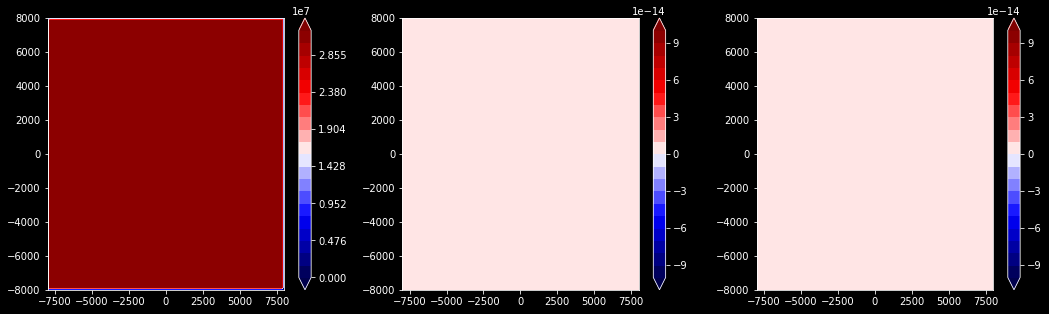

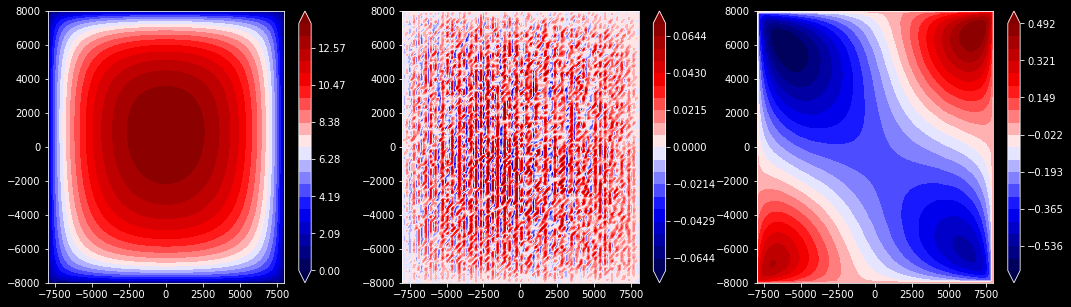

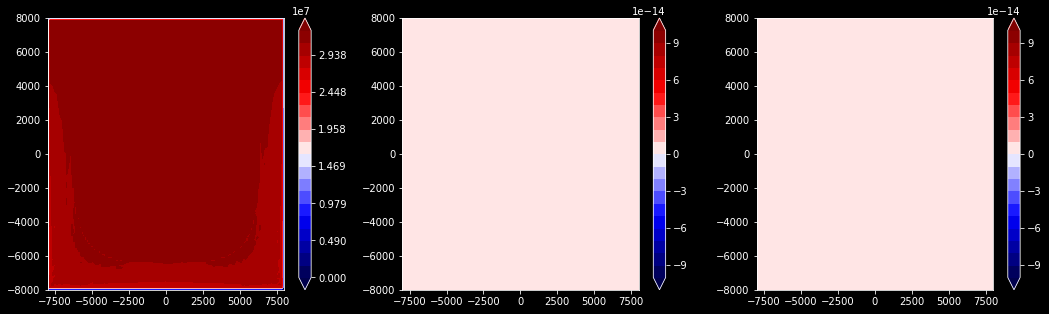

In [10]:
plot_fields(qdm.m, initial_traction)
plot_fields(qdm.m, initial_slip_deficit)
plot_fields(qdm.m, initial_traction2)

In [11]:
derivs = make_qd_derivs(qdm, qd_cfg, slip_to_traction)

In [12]:
initial_t = 0.0
initial_slip = -initial_slip_deficit
initial_state = np.ones(qdm.m.tris.shape[0] * 3) * state_i
initial_conditions = np.concatenate((initial_slip, initial_state))
h_t = []
h_y = []
integrator = RK45(derivs, initial_t, initial_conditions, 1e20, atol = qd_cfg['timestep_tol'], rtol = qd_cfg['timestep_tol'])

In [ ]:
from IPython.display import clear_output
siay = 60 * 60 * 24 * 365.25
for i in range(10000):
    assert(integrator.step() == None)
    h_t.append(integrator.t)
    h_y.append(integrator.y.copy())
    clear_output()
    print(i, integrator.t / siay)
    if len(h_t) > 1:
        dt = h_t[-1] - h_t[-2]
        dx = (L * 2) / (n_fault - 1)
        dt_dynamic = mesh_L / qd_cfg['cs'] / 3.0
        dt_evol = 0.5 * qd_cfg['Dc'] / qdm.max_V
        print('time step vs lapusta', dt, dt_evol, dt_dynamic, qdm.max_V)
    #plot_setting(integrator.t, integrator.y, qdm, qd_cfg, slip_to_traction)
    if i % 500 == 0:
        np.save('results_initial_creep.npy', np.array([qdm.m, qd_cfg, h_t, h_y], dtype = np.object))

15 50.25723060969476
time step vs lapusta 108783.59319996834 115668.06376038471 0.019683583468224027 5.1872572298170923e-08
